In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import pickle
import math

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load Data

In [3]:
# Reads data from a pickle file
# Data is stored as a lists of images and ground truths in a dictionary
# Each index in the seperate list corrispond to each other
class PickleDataset(Dataset):
  def __init__(self, pickle_path, transform=None):
    # Opens file and reads lists in
    file = open(pickle_path, 'rb')
    data = pickle.load(file)
    file.close()
    self.features = data["features"]
    self.labels = data["labels"]
    #
    self.transform = transform

  def __len__(self):
    return self.features.shape[0]

  def __getitem__(self, idx):
    feature = self.features[idx]
    label = self.labels[idx]

    label = torch.tensor(label)

    if self.transform:
      feature = self.transform(feature)

    return feature, label


## Training Data

In [4]:
train_path = 'drive/MyDrive/College/Research/ACDC_DataSet/processed_henry/train_data.pkl'

# # Set seed for repeatability
seed_val = 1
torch.manual_seed(seed_val)
np.random.seed(seed_val)

# Define the validation ratio to be used
valid_ratio = 0.9

transform = torchvision.transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.1307,), (0.3081,))
          ])
label_transform = transforms.ToTensor()

train_dataset = PickleDataset(train_path, transform=transform)#, target_transform=label_transform)

# Number of images to use for training
nb_train = math.ceil((1.0 - valid_ratio) * len(train_dataset))
# Number of images to use for validation
nb_valid =  math.floor(valid_ratio * len(train_dataset))

# Randomly split into training and validation data
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_dataset, [nb_train, nb_valid])

print(f"Training dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")

# create your dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=20, shuffle=True)

print(f"Training batches: {len(train_dataloader)}")
print(f"Valid batches: {len(valid_dataloader)}")

Training dataset length: 162
Valid dataset length: 1454
Training batches: 9
Valid batches: 73


## Test Data

In [5]:
test_path = 'drive/MyDrive/College/Research/ACDC_DataSet/processed_henry/test_data.pkl'

test_dataset = PickleDataset(test_path, transform=transform)#, target_transform=label_transform)
print(f"Training dataset length: {len(train_dataset)}")
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=True)
print(f"Test batches: {len(test_dataloader)}")

Training dataset length: 162
Test batches: 15


# Define Network and Training Loop

## Network

In [7]:
# Two 3x3 convolutions that maintain image size
# Each convolution is followed by a relu activation
# Inputs
#   in_c: number of channels/features inputted into the convolution
#   mid_c: number of channels/features between the two convolutions
#   out_c: number of channels/features outputted by the convolution
def double_conv(in_c, mid_c, out_c):
  conv = nn.Sequential(
      nn.Conv2d(
        in_channels = in_c,              
        out_channels = mid_c,            
        kernel_size = 3,                                 
        padding = 1                 
      ),                              
      nn.ReLU(inplace=True),
      nn.Conv2d(
        in_channels = mid_c,              
        out_channels = out_c,            
        kernel_size = 3,
        padding = 1                            
      ),                              
      nn.ReLU(inplace=True)
  )
  return conv

# The model for unet
# cade based off this video: https://www.youtube.com/watch?v=u1loyDCoGbE
# 4 down convolution "blocks"
# 4 up convolution "blocks"
# 1 bottle neck convolution block
class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    
    # encoder
    self.pool = nn.MaxPool2d(kernel_size=2, stride = 2) #Max pool, decreases image size by half in each dimension, by 4 total
    # each convolution increases features by 2 (exception in down_conv1)
    self.down_conv1 = double_conv(1, 64, 64)
    self.down_conv2 = double_conv(64, 128, 128)
    self.down_conv3 = double_conv(128, 256, 256)
    self.down_conv4 = double_conv(256, 512, 512)
    # bottle conv
    self.bottle_conv = double_conv(512, 1024, 512) #Exapanda and contracts features
    # decoder
    # each transpose convolution increases image size by 2 in each dimension, 4 in total
    # each up_conv decreases features by 4
    self.trans1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.up_conv1 = double_conv(1024, 512, 256)
    self.trans2 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.up_conv2 = double_conv(512, 256, 128)
    self.trans3 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.up_conv3 = double_conv(256, 128, 64)
    self.trans4 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.up_conv4 = double_conv(128, 64, 64)
    # out
    # returns number of features equal to classes (4)
    self.out = nn.Conv2d(in_channels = 64, out_channels = 4, kernel_size = 3, padding = 1)

  def forward(self,img):
    # encoder
    # a down convolution followed by max pool
    # increases features by 2, decreases image size by 4
    #------------------------
    x1 = self.down_conv1(img)
    p1 = self.pool(x1)
    #------------------------
    x2 = self.down_conv2(p1)
    p2 = self.pool(x2)
    #------------------------
    x3 = self.down_conv3(p2)
    p3 = self.pool(x3)
    #------------------------
    x4 = self.down_conv4(p3)
    p4 = self.pool(x4)
    #------------------------

    # bottleneck
    # adds more weights for network to change
    #------------------------
    bottle = self.bottle_conv(p4)
    #------------------------

    # decoder
    # First increases image size
    # Then concatanates a similar sized output from a down_conv to the results
    # Then does an up_conv decreasing features
    #------------------------
    u4 = self.trans1(bottle)
    c4 = torch.cat([x4,u4], dim=1)
    y4 = self.up_conv1(c4)
    #------------------------
    u3 = self.trans2(y4)
    c3 = torch.cat([x3,u3], dim=1)
    y3 = self.up_conv2(c3)
    #------------------------
    u2 = self.trans3(y3)
    c2 = torch.cat([x2,u2], dim=1)
    y2 = self.up_conv3(c2)
    #------------------------
    u1 = self.trans4(y2)
    c1 = torch.cat([x1,u1], dim=1)
    y1 = self.up_conv4(c1)
    #------------------------
    # retirns image with proper number of features
    out = self.out(y1)
    return out

  # Initializes model with normally distributed xavier weights for all convolutions
  # uses gain of sqrt(2)
  def initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal(m.weight,gain=np.sqrt(2))

## Training/Testing Loop

In [8]:
# Selects data from validation loader so that it is not validating on too much information
data_iter = iter(test_dataloader)
valid_imgs, valid_labels = data_iter.next()

# trains model
def train_network(model, train_loader, optimizer, criterion, max_epochs):
  min_valid_loss = np.inf
  val_loss = []
  # loop over epochs
  for epoch in range(max_epochs):
    train_loss = 0.0
    # Training loop
    for inputs, labels in train_loader:
      # Transfer Data to device
      inputs, labels = inputs.to(device), labels.long().to(device)
      # Clear the gradients
      optimizer.zero_grad()      
      #steps data foward and backwards through model
      outputs = model(inputs)           # Forward Pass
      loss = criterion(outputs, labels) # Find the Loss
      loss.backward()                   # Send Loss backward
      optimizer.step()                  # Update Weights
      # Calculate Loss
      train_loss += loss.item()
    #Calculates loss on validation
    valid_loss = 0.0
    with torch.no_grad():
      # Transfer Data to device
      inputs, labels = valid_imgs.to(device), valid_labels.long().to(device)
      # Forward Pass
      torch.cuda.empty_cache()
      outputs = model(inputs)
      # Find the Loss
      loss = criterion(outputs, labels)
      # Calculate Loss
      valid_loss = loss.item()
      val_loss.append(valid_loss)
      # prints losses
      if(np.mod(epoch,10)==0):
        print(f'Epoch {epoch+1}:')
        print(f'\tTraining Loss: {train_loss / len(train_loader):.5f}')
        print(f'\tValidation Loss: {valid_loss:.5f}')
      # saves best model
      if min_valid_loss > valid_loss:
        # print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), PATH)
  return val_loss

# tests model on training data
def test_train(model, test_loader, criterion):
  test_loss = 0.0
  #testing loop
  for inputs, labels in test_loader:
    # Transfer Data to device
    inputs, labels = inputs.to(device), labels.long().to(device)
    # passes data forward
    outputs = model(inputs)           # Forward Pass
    loss = criterion(outputs, labels) # Find the Loss
    test_loss += loss.item()
  # prints losses
  print(f'Test Loss: {test_loss / len(test_loader):.5f}')
# Displays a tensor as an image
def imshow(img):
  img = (img - torch.min(img))/torch.max(img - torch.min(img))
  np_img = img.numpy()      # convert to numpy
  plt.imshow(np.transpose(np_img, (1,2,0)))
  plt.show()   

## Selects device

In [10]:
# Selects device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Training

## Unweighted cross entropy loss

Creates model and sends it to the device

In [11]:
# Creates model
unet = UNet()
# number of parameters
print('Number of parameters =', sum([p.numel() for p in unet.parameters()]))
# Send network to device
unet.to(device)
print("---")

Number of parameters = 25113156
---


Defines training and network

In [12]:
# path location to save trained model on
PATH = 'drive/MyDrive/College/Research/unet_cross_loss.pth'
#   network parameters
loss_criterion = nn.CrossEntropyLoss()
learning_rate = 5e-4
optimizer=optim.Adam(unet.parameters(), lr = learning_rate, weight_decay =0.1)

Training

In [13]:
val_loss = train_network(unet, train_dataloader, optimizer=optimizer, criterion=loss_criterion, max_epochs=1000)

Epoch 1:
	Training Loss: 1.22938
	Validation Loss: 0.78005
Epoch 11:
	Training Loss: 0.17677
	Validation Loss: 0.16885
Epoch 21:
	Training Loss: 0.16723
	Validation Loss: 0.15999
Epoch 31:
	Training Loss: 0.17686
	Validation Loss: 0.16431
Epoch 41:
	Training Loss: 0.16944
	Validation Loss: 0.16324
Epoch 51:
	Training Loss: 0.17763
	Validation Loss: 0.16327
Epoch 61:
	Training Loss: 0.17935
	Validation Loss: 0.17215
Epoch 71:
	Training Loss: 0.17202
	Validation Loss: 0.16539
Epoch 81:
	Training Loss: 0.18124
	Validation Loss: 0.16702
Epoch 91:
	Training Loss: 0.16783
	Validation Loss: 0.16813
Epoch 101:
	Training Loss: 0.17240
	Validation Loss: 0.17072
Epoch 111:
	Training Loss: 0.19074
	Validation Loss: 0.17381
Epoch 121:
	Training Loss: 0.19391
	Validation Loss: 0.17015
Epoch 131:
	Training Loss: 0.16097
	Validation Loss: 0.15515
Epoch 141:
	Training Loss: 0.16603
	Validation Loss: 0.15113
Epoch 151:
	Training Loss: 0.15693
	Validation Loss: 0.15035
Epoch 161:
	Training Loss: 0.15914


Loads best model

In [14]:
# Load saved net
unet.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Runs test data on model

In [15]:
# runs test data on model
test_train(unet, test_dataloader, loss_criterion)

Test Loss: 0.15300


Display example segmentations



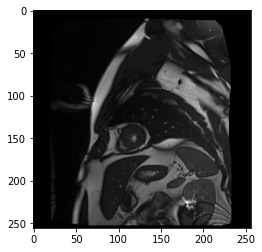

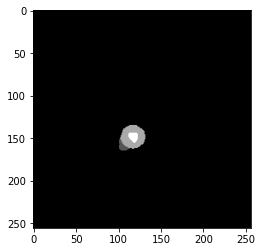

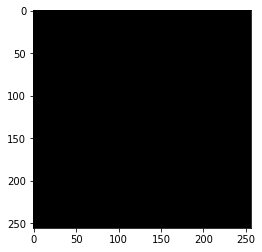

In [16]:
# Get random testing images
data_iter = iter(test_dataloader)
imgs, labels = data_iter.next()
# Show images (that are currently tensors) and their predictions
n_images = 1
imshow(torchvision.utils.make_grid(imgs[n_images,]))
imshow(torchvision.utils.make_grid(labels[n_images,]))
# forward pass through network
with torch.no_grad():
  outputs = unet(imgs[n_images].unsqueeze(dim=1).to(device))
  _, predicted = torch.max(F.log_softmax(outputs,dim=1), 1)
# predictions
imshow(torchvision.utils.make_grid(predicted.cpu().detach()))

## Weighted cross entropy loss

Creates model and sends it to the device

In [28]:
# Creates model
weighted_loss_unet = UNet()
# number of parameters
print('Number of parameters =', sum([p.numel() for p in weighted_loss_unet.parameters()]))
# Send network to device
weighted_loss_unet.to(device)
print("---")

Number of parameters = 25113156
---


Defines training and network

In [47]:
# path location to save trained model on
PATH = 'drive/MyDrive/College/Research/unet_weighted_loss.pth'



# network parameters
weights = torch.tensor([0.1, 2.0, 2.0, 1.75]).to(device) # weights of classes to be classified
loss_criterion = nn.CrossEntropyLoss(weight=weights)
learning_rate = 5e-4
optimizer=optim.Adam(weighted_loss_unet.parameters(), lr = learning_rate, weight_decay =0.1)

Train

In [30]:
val_loss = train_network(weighted_loss_unet, train_dataloader, optimizer=optimizer, criterion=loss_criterion, max_epochs=1000)

Epoch 1:
	Training Loss: 2.29407
	Validation Loss: 1.30994
Epoch 11:
	Training Loss: 0.99690
	Validation Loss: 0.99031
Epoch 21:
	Training Loss: 0.93587
	Validation Loss: 0.92433
Epoch 31:
	Training Loss: 0.92817
	Validation Loss: 0.89437
Epoch 41:
	Training Loss: 0.83077
	Validation Loss: 0.79651
Epoch 51:
	Training Loss: 0.81641
	Validation Loss: 0.77331
Epoch 61:
	Training Loss: 0.80826
	Validation Loss: 0.74832
Epoch 71:
	Training Loss: 0.76588
	Validation Loss: 0.73534
Epoch 81:
	Training Loss: 0.77064
	Validation Loss: 0.73381
Epoch 91:
	Training Loss: 0.77879
	Validation Loss: 0.75484
Epoch 101:
	Training Loss: 0.74790
	Validation Loss: 0.70888
Epoch 111:
	Training Loss: 0.73314
	Validation Loss: 0.71473


KeyboardInterrupt: ignored

Load saved net

In [48]:
# Load saved net
weighted_loss_unet.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Runs test data on model

In [49]:
# runs test data on model
test_train(weighted_loss_unet, test_dataloader, nn.CrossEntropyLoss())

Loss with weights
Test Loss: 0.75264
Loss wothout weights
Test Loss: 0.36224


Display example segmentations

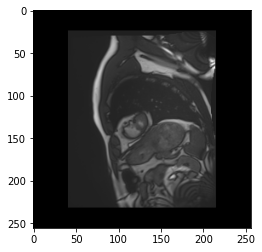

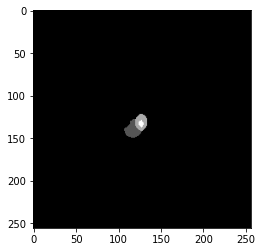

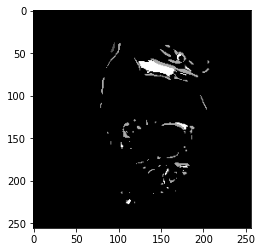

In [60]:
# Get random testing images
data_iter = iter(test_dataloader)
imgs, labels = data_iter.next()
# Show images (that are currently tensors) and their predictions
n_images = 1
imshow(torchvision.utils.make_grid(imgs[n_images,]))
imshow(torchvision.utils.make_grid(labels[n_images,]))
# forward pass through network
with torch.no_grad():
  outputs = weighted_loss_unet(imgs[n_images].unsqueeze(dim=1).to(device))
  _, predicted = torch.max(F.log_softmax(outputs,dim=1), 1)
# predictions
imshow(torchvision.utils.make_grid(predicted.cpu().detach()))